# VGG-19

### Imports and Device Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cuda


### Data Preprocessing and Augmentation

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])


### Load CIFAR-100 Dataset

In [3]:
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


### Define VGG-19 Model

In [4]:
cfg = {
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M',
          512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

def make_layers(cfg):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class VGG19(nn.Module):
    def __init__(self, num_classes=100):
        super(VGG19, self).__init__()
        self.features = make_layers(cfg['E'])
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


### Model Initialization, Loss Function, Optimizer

In [7]:
model = VGG19().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Training and Validation Loop

In [9]:
train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in range(150):
    model.train()
    running_loss = 0
    correct, total = 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(trainloader))
    train_acc.append(100 * correct / total)

    model.eval()
    running_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss.append(running_loss / len(testloader))
    val_acc.append(100 * correct / total)

    print(f"Epoch {epoch+1}: Train Acc={train_acc[-1]:.2f}%, Val Acc={val_acc[-1]:.2f}%")


Epoch 1: Train Acc=36.75%, Val Acc=36.62%
Epoch 2: Train Acc=38.68%, Val Acc=39.32%
Epoch 3: Train Acc=40.21%, Val Acc=40.42%
Epoch 4: Train Acc=41.79%, Val Acc=42.96%
Epoch 5: Train Acc=43.16%, Val Acc=43.01%
Epoch 6: Train Acc=44.76%, Val Acc=42.85%
Epoch 7: Train Acc=46.35%, Val Acc=44.19%
Epoch 8: Train Acc=47.62%, Val Acc=45.23%
Epoch 9: Train Acc=49.30%, Val Acc=46.31%
Epoch 10: Train Acc=50.39%, Val Acc=48.45%
Epoch 11: Train Acc=51.82%, Val Acc=47.83%
Epoch 12: Train Acc=52.93%, Val Acc=49.39%
Epoch 13: Train Acc=54.30%, Val Acc=48.08%
Epoch 14: Train Acc=54.47%, Val Acc=51.13%
Epoch 15: Train Acc=55.96%, Val Acc=51.50%
Epoch 16: Train Acc=57.09%, Val Acc=52.30%
Epoch 17: Train Acc=58.42%, Val Acc=52.11%
Epoch 18: Train Acc=58.93%, Val Acc=52.66%
Epoch 19: Train Acc=59.15%, Val Acc=51.68%
Epoch 20: Train Acc=60.46%, Val Acc=53.88%
Epoch 21: Train Acc=59.92%, Val Acc=53.75%
Epoch 22: Train Acc=61.98%, Val Acc=54.15%
Epoch 23: Train Acc=63.32%, Val Acc=53.92%
Epoch 24: Train Acc=

### Plot Loss and Accuracy Curves

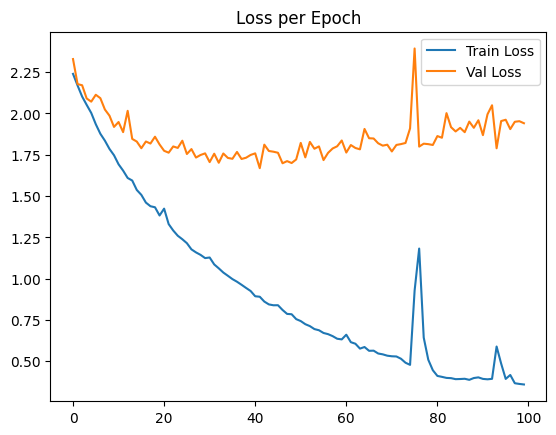

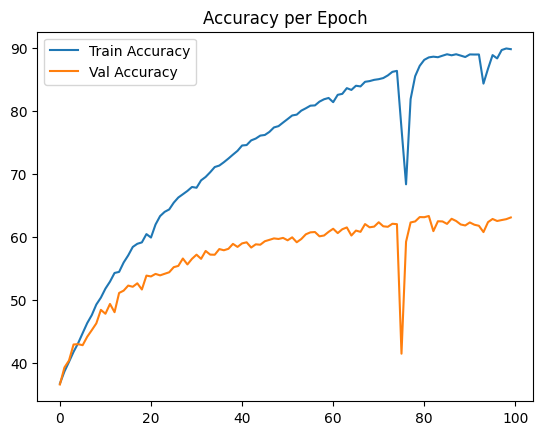

In [10]:
plt.figure()
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title("Loss per Epoch")
plt.show()

plt.figure()
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.legend()
plt.title("Accuracy per Epoch")
plt.show()


### Visualize Convolutional Filters (Before & After Training)

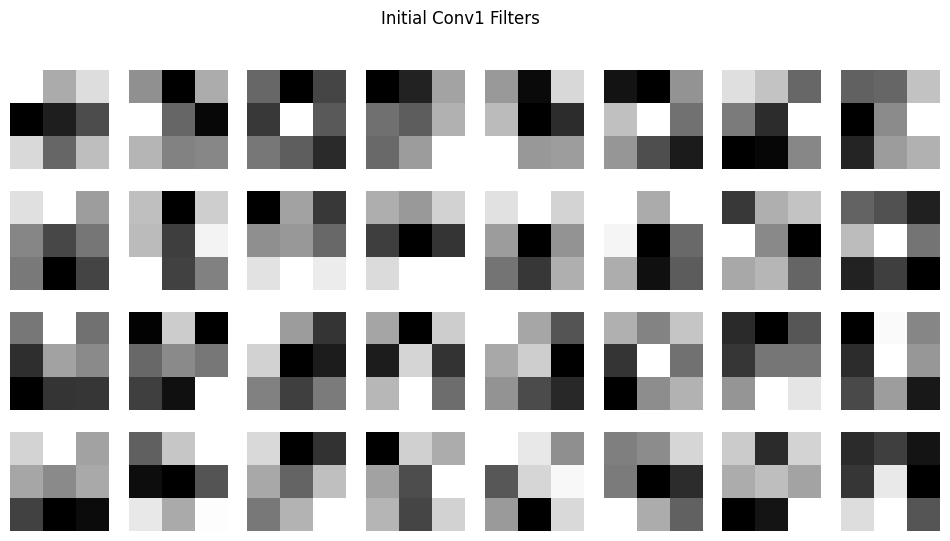

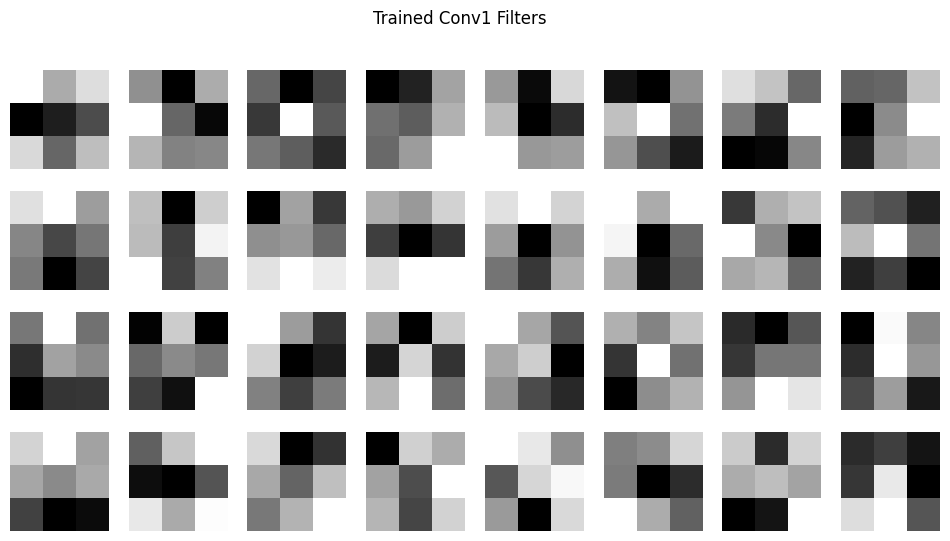

In [11]:
def visualize_filters(weights, title):
    weights = weights.cpu().detach().numpy()
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < weights.shape[0]:
            img = weights[i, 0]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
    plt.suptitle(title)
    plt.show()

initial_weights = model.features[0].weight.clone()
visualize_filters(initial_weights, "Initial Conv1 Filters")
visualize_filters(model.features[0].weight, "Trained Conv1 Filters")


### Evaluate Model Performance on Test Set

In [12]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, output_dict=True)


### Evaluation Metrics and Summary Table

In [13]:
TP = np.diag(cm).sum()
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

metrics_table = pd.DataFrame({
    'Metric': ['True Positives', 'False Positives', 'False Negatives', 'True Negatives', 'Accuracy', 'F1-Score'],
    'Value': [
        TP,
        FP.sum(),
        FN.sum(),
        TN.sum(),
        accuracy_score(all_labels, all_preds),
        f1_score(all_labels, all_preds, average='macro')
    ]
})
print(metrics_table)


            Metric          Value
0   True Positives    6310.000000
1  False Positives    3690.000000
2  False Negatives    3690.000000
3   True Negatives  361620.000000
4         Accuracy       0.631000
5         F1-Score       0.634733


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# 1) Define VGG-19
class VGG19(nn.Module):
    def __init__(self, num_classes=100):
        super(VGG19, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 2
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 3
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 4
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 5
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        # After 5 pools on 32×32 → 1×1
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096), nn.ReLU(inplace=True), nn.Dropout(),
            nn.Linear(4096, 4096),       nn.ReLU(inplace=True), nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 2) Data loaders
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(
    root='./data', train=True,  download=True, transform=transform_train)
testset  = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True,  num_workers=4)
testloader  = DataLoader(testset,  batch_size=100, shuffle=False, num_workers=4)

# 3) Instantiate model, loss, optimizer, scheduler
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = VGG19(num_classes=100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05,
                      momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# 4) Training & testing functions
def train(epoch):
    model.train()
    total_loss = 0.0
    for inputs, targets in tqdm(trainloader, desc=f"Epoch {epoch}", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss    = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
    scheduler.step()
    avg_loss = total_loss / len(trainset)
    print(f"Train Epoch {epoch} → Loss: {avg_loss:.4f}")

def test():
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, pred = outputs.max(1)
            correct += pred.eq(targets).sum().item()
            total   += targets.size(0)
    acc = 100. * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return acc

# 5) Training loop with early stopping
best_acc   = 0.0
patience   = 10    # stop if no improvement after 10 epochs
no_improve = 0
max_epochs = 100

for epoch in range(1, max_epochs + 1):
    train(epoch)
    acc = test()

    if acc > best_acc:
        best_acc   = acc
        no_improve = 0
        torch.save(model.state_dict(), 'vgg19_cifar100.pth')
        print(f"→ New best model saved (acc {best_acc:.2f}%)")
    else:
        no_improve += 1
        print(f"→ No improvement for {no_improve} epoch(s)")

    if no_improve >= patience:
        print(f"→ Early stopping at epoch {epoch} (no improvement in last {patience} epochs)")
        break

print(f"Best Test Accuracy Achieved: {best_acc:.2f}%")


100%|██████████| 169M/169M [01:30<00:00, 1.86MB/s] 


Train Epoch 1 — Loss: 4.6072
Test Accuracy: 1.00%


Train Epoch 2 — Loss: 4.6068
Test Accuracy: 1.00%


Train Epoch 3 — Loss: 4.6068
Test Accuracy: 1.00%


Train Epoch 4 — Loss: 4.6067
Test Accuracy: 1.00%


Train Epoch 5 — Loss: 4.6067
Test Accuracy: 1.00%


Train Epoch 6 — Loss: 4.6067
Test Accuracy: 1.00%


Train Epoch 7 — Loss: 4.6066
Test Accuracy: 1.00%


Train Epoch 8 — Loss: 4.6067
Test Accuracy: 1.00%


KeyboardInterrupt: 

# ResNet-50

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# 1) Define Bottleneck block and ResNet-50
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        return self.relu(out)

class ResNet50(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet50, self).__init__()
        self.in_channels = 64

        # Initial conv layer for CIFAR
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Residual layers
        self.layer1 = self._make_layer(Bottleneck, 64, 3)
        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, 6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, 3, stride=2)

        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# 2) Data loaders
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                         download=True, transform=transform_train)
testset  = torchvision.datasets.CIFAR100(root='./data', train=False,
                                         download=True, transform=transform_test)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True,  num_workers=4)
testloader  = DataLoader(testset,  batch_size=100, shuffle=False, num_workers=4)

# 3) Instantiate model, loss, optimizer, scheduler
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = ResNet50(num_classes=100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# 4) Training & testing functions
def train(epoch):
    model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(trainloader, desc=f"Epoch {epoch}", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    scheduler.step()
    print(f"Train Epoch {epoch} → Loss: {running_loss/len(trainset):.4f}")

def test():
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
    acc = 100. * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return acc

# 5) Training loop with early stopping
best_acc = 0.0
patience = 10
no_improve = 0
max_epochs = 100

for epoch in range(1, max_epochs + 1):
    train(epoch)
    acc = test()
    if acc > best_acc:
        best_acc = acc
        no_improve = 0
        torch.save(model.state_dict(), 'resnet50_cifar100.pth')
        print(f"→ New best model saved (acc {best_acc:.2f}%)")
    else:
        no_improve += 1
        print(f"→ No improvement for {no_improve} epoch(s)")
    if no_improve >= patience:
        print(f"→ Early stopping at epoch {epoch} (no improvement in last {patience} epochs)")
        break

print(f"Best Test Accuracy Achieved: {best_acc:.2f}%")


# DenseNet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary

# DenseNet components
def conv_block(in_channels, growth_rate):
    """
    A single convolutional layer within a dense block.
    Applies: BN -> ReLU -> Conv(1x1) -> BN -> ReLU -> Conv(3x3)
    """
    return nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False),
        nn.BatchNorm2d(4 * growth_rate),
        nn.ReLU(inplace=True),
        nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
    )

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(conv_block(in_channels + i * growth_rate, growth_rate))

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            out = layer(torch.cat(features, 1))
            features.append(out)
        return torch.cat(features, 1)

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.net(x)

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), 
                 num_init_features=64, num_classes=100):
        super(DenseNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Dense blocks and transitions
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(num_layers, num_features, growth_rate)
            self.features.add_module(f"denseblock{i+1}", block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = Transition(num_features, num_features // 2)
                self.features.add_module(f"transition{i+1}", trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('bn_final', nn.BatchNorm2d(num_features))

        # Classifier
        self.classifier = nn.Linear(num_features, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        return self.classifier(out)

# Instantiate DenseNet-121 for CIFAR-100
# block_config for DenseNet-121: (6, 12, 24, 16)
densenet121 = DenseNet(growth_rate=32, block_config=(6, 12, 24, 16), 
                       num_init_features=64, num_classes=100)

# Model summary (input size: 3x32x32 for CIFAR)
summary(densenet121, (3, 32, 32))

# Data loading and transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)

# Training and evaluation loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
densenet121.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet121.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

def train(epoch):
    densenet121.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = densenet121(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f"Epoch {epoch} | Loss: {running_loss/len(trainloader):.4f} | Accuracy: {100.*correct/total:.2f}%")


def test(epoch):
    densenet121.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = densenet121(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    print(f"Test Epoch {epoch} | Loss: {test_loss/len(testloader):.4f} | Accuracy: {100.*correct/total:.2f}%")

# Main training loop
for epoch in range(1, 101):
    train(epoch)
    test(epoch)
    scheduler.step()


# EfficientNetB0

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# 1) Define EfficientNet-B0
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=100, pretrained=False):
        super(EfficientNetB0, self).__init__()
        # Load pretrained EfficientNet-B0 backbone
        backbone = torchvision.models.efficientnet_b0(pretrained=pretrained)
        # Use feature extractor and replace classifier
        self.features = backbone.features
        in_features = backbone.classifier[1].in_features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p=backbone.classifier[0].p if hasattr(backbone.classifier[0], 'p') else 0.2),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 2) Data loaders
# CIFAR-100 images are 32x32; EfficientNet expects 224x224
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)
testset  = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True,  num_workers=4)
testloader  = DataLoader(testset,  batch_size=100, shuffle=False, num_workers=4)

# 3) Instantiate model, loss, optimizer, scheduler
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = EfficientNetB0(num_classes=100, pretrained=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# 4) Training & testing functions
def train(epoch):
    model.train()
    total_loss = 0.0
    for inputs, targets in tqdm(trainloader, desc=f"Epoch {epoch}", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss    = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
    scheduler.step()
    avg_loss = total_loss / len(trainset)
    print(f"Train Epoch {epoch} → Loss: {avg_loss:.4f}")


def test():
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, pred = outputs.max(1)
            correct += pred.eq(targets).sum().item()
            total   += targets.size(0)
    acc = 100. * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return acc

# 5) Training loop with early stopping
best_acc   = 0.0
patience   = 10    # stop if no improvement after 10 epochs
no_improve = 0
max_epochs = 100

for epoch in range(1, max_epochs + 1):
    train(epoch)
    acc = test()

    if acc > best_acc:
        best_acc   = acc
        no_improve = 0
        torch.save(model.state_dict(), 'efficientnetb0_cifar100.pth')
        print(f"→ New best model saved (acc {best_acc:.2f}%)")
    else:
        no_improve += 1
        print(f"→ No improvement for {no_improve} epoch(s)")

    if no_improve >= patience:
        print(f"→ Early stopping at epoch {epoch} (no improvement in last {patience} epochs)")
        break

print(f"Best Test Accuracy Achieved: {best_acc:.2f}%")
